# 미니 프로젝트 : 네이버 영화리뷰 감성분석

네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc) 데이터 셋을 활용하여 한국어 텍스트의 감정분석을 진행해보자.

## 1. 데이터 준비 및 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


# 데이터 파일 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

다음의 기능을 수행하는 함수 `data_loader` 을 정의한다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)   # 중복 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}    # {단어:숫자} 딕셔너리 생성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


{숫자:단어} 의 딕셔너리 `index_to_word` 생성한다.

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

다음의 기능을 수행하는 함수들을 정의한다.
- `get_encoded_sentence` : 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
- `get_encoded_sentences` : 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
- `get_decoded_sentence` : 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
- `get_decoded_sentences` : 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

encode된 텍스트가 정상적으로 decode되는지 확인해보자.

In [6]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3. 모델구성을 위한 데이터 분석 및 가공

###  적절한 최대 문장 길이 지정

문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


위에서는 `maxlen`= 41 이 된다.

### padding 적용
`keras.preprocessing.sequence.pad_sequences` 을 활용하여 패딩을 추가한다.  

이때, padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생하는 것을 확인하기위해 두 가지 방법 각각 적용하여 진행한다.

In [8]:
X_train_pre = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_pre = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 41)


In [9]:
X_train_post = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test_post = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train_post.shape)

(146182, 41)


In [10]:
print(X_train_pre[0])
print(get_decoded_sentence(X_train_pre[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [11]:
print(X_train_post[0])
print(get_decoded_sentence(X_train_post[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


앞과 뒤에 각각 패딩이 적용된 것을 확인 할 수 있다. 

## 4. 모델구성 및 validation set 구성
### validation set 분리
146182 개의 train set 중에 45000개를 validation set 으로 사용한다.

In [12]:
# validation set 10000건 분리
X_val_pre = X_train_pre[:45000]    # pre 패딩된 train set 분리
X_val_post = X_train_post[:45000]  # post 패딩된 train set 분리
y_val = y_train[:45000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[45000:]
partial_X_train_post = X_train_post[45000:]
partial_y_train = y_train[45000:]


# validation set 갯수
print(X_val_pre.shape)
print(X_val_post.shape)
print(y_val.shape)

# 나머지 train set 갯수
print(partial_X_train_pre.shape)
print(partial_X_train_post.shape)
print(partial_y_train.shape)

(45000, 41)
(45000, 41)
(45000,)
(101182, 41)
(101182, 41)
(101182,)


### 모델 생성

텍스트 데이터를 다루는 다양한 모델을 구성해보자. 이때, padding을 앞에 적용한 데이터와 뒤에 적용한 데이터의 모델 훈련 및 성능 차이를 보기 위해 각각의 모델을 생성한다.
- __Recurrent Neural Network(RNN)__
- __1-D Convolution Neural Network(1-D CNN)__
- __GlobalMaxPooling1D() 레이어__

### Recurrent Neural Network(RNN)

In [13]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_pre = keras.Sequential()
model_rnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_pre.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_rnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_post = keras.Sequential()
model_rnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_post.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_post.add(keras.layers.Dense(8, activation='relu'))
model_rnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 1-D Convolution Neural Network(1-D CNN)

In [15]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_pre = keras.Sequential()
model_1dcnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.MaxPooling1D(5))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_post = keras.Sequential()
model_1dcnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.MaxPooling1D(5))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_post.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_post.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### GlobalMaxPooling1D() 레이어

In [17]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_pre = keras.Sequential()
model_gmp_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_pre.add(keras.layers.GlobalMaxPooling1D())
model_gmp_pre.add(keras.layers.Dense(8, activation='relu'))
model_gmp_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_pre.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [18]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_post = keras.Sequential()
model_gmp_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_post.add(keras.layers.GlobalMaxPooling1D())
model_gmp_post.add(keras.layers.Dense(8, activation='relu'))
model_gmp_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_post.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


----
## 5. 모델 학습, 학습 시각화 및 평가
### 5-1. RNN 모델 훈련 - pre 패딩 데이터 사용
패딩을 앞에 넣은 데이터셋으로 모델을 훈련

In [19]:
model_rnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_pre = model_rnn_pre.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 6s 15ms/step - loss: 0.6084 - accuracy: 0.7155 - val_loss: 0.3791 - val_accuracy: 0.8412
Epoch 2/5
198/198 [==============================] - 2s 11ms/step - loss: 0.3524 - accuracy: 0.8546 - val_loss: 0.3504 - val_accuracy: 0.8489
Epoch 3/5
198/198 [==============================] - 2s 11ms/step - loss: 0.3167 - accuracy: 0.8688 - val_loss: 0.3477 - val_accuracy: 0.8498
Epoch 4/5
198/198 [==============================] - 2s 11ms/step - loss: 0.3010 - accuracy: 0.8760 - val_loss: 0.3517 - val_accuracy: 0.8491
Epoch 5/5
198/198 [==============================] - 2s 11ms/step - loss: 0.2836 - accuracy: 0.8858 - val_loss: 0.3510 - val_accuracy: 0.8502


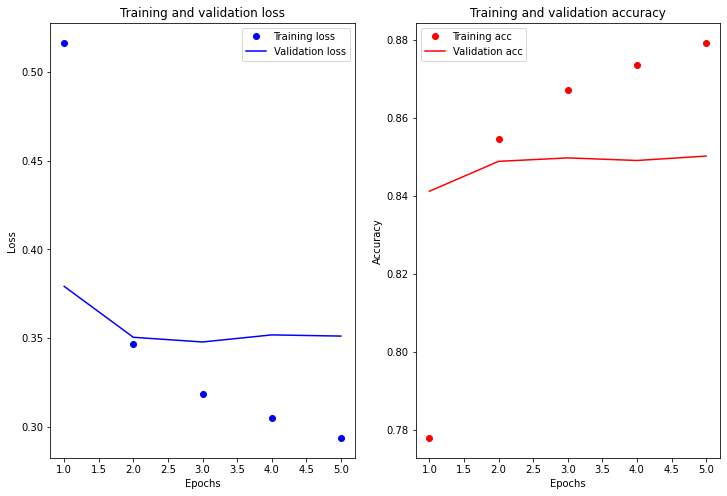

In [20]:
history_rnn_pre_dict = history_rnn_pre.history

acc = history_rnn_pre_dict['accuracy']
val_acc = history_rnn_pre_dict['val_accuracy']
loss = history_rnn_pre_dict['loss']
val_loss = history_rnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습이 끝난 모델을 test set 으로 평가

In [21]:
results = model_rnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3623 - accuracy: 0.8431
[0.3622892200946808, 0.8431352376937866]


----
### 5-2. RNN 모델 훈련 - post 패딩 데이터 사용

In [22]:
model_rnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_post = model_rnn_post.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 4s 13ms/step - loss: 0.6685 - accuracy: 0.5526 - val_loss: 0.4069 - val_accuracy: 0.8312
Epoch 2/5
198/198 [==============================] - 2s 11ms/step - loss: 0.3709 - accuracy: 0.8491 - val_loss: 0.3506 - val_accuracy: 0.8474
Epoch 3/5
198/198 [==============================] - 2s 11ms/step - loss: 0.3175 - accuracy: 0.8695 - val_loss: 0.3470 - val_accuracy: 0.8488
Epoch 4/5
198/198 [==============================] - 2s 11ms/step - loss: 0.2994 - accuracy: 0.8765 - val_loss: 0.3573 - val_accuracy: 0.8462
Epoch 5/5
198/198 [==============================] - 2s 11ms/step - loss: 0.2890 - accuracy: 0.8787 - val_loss: 0.3519 - val_accuracy: 0.8470


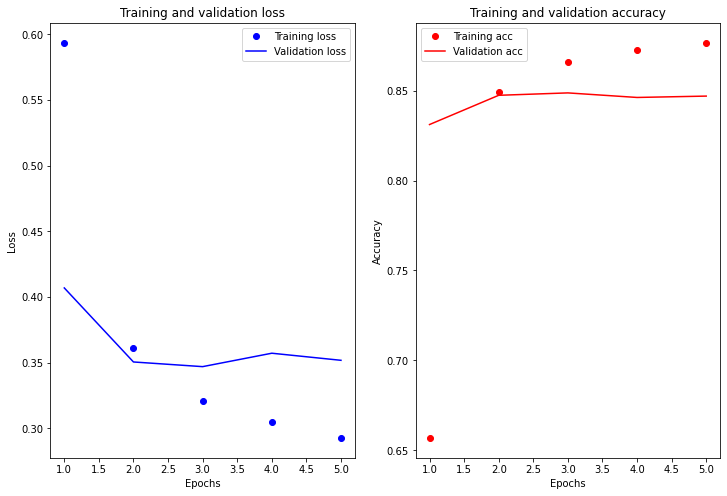

In [23]:
history_rnn_post_dict = history_rnn_post.history

acc = history_rnn_post_dict['accuracy']
val_acc = history_rnn_post_dict['val_accuracy']
loss = history_rnn_post_dict['loss']
val_loss = history_rnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
results = model_rnn_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3615 - accuracy: 0.8423
[0.36150267720222473, 0.8422605395317078]


----
### 5-3. 1-D Convolution Neural Network(1-D CNN) - pre 패딩 데이터 사용

In [25]:
model_1dcnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_pre = model_1dcnn_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 7s 23ms/step - loss: 0.6597 - accuracy: 0.5912 - val_loss: 0.4815 - val_accuracy: 0.7570
Epoch 2/5
198/198 [==============================] - 2s 8ms/step - loss: 0.4491 - accuracy: 0.7804 - val_loss: 0.4611 - val_accuracy: 0.7649
Epoch 3/5
198/198 [==============================] - 2s 8ms/step - loss: 0.4044 - accuracy: 0.8072 - val_loss: 0.4612 - val_accuracy: 0.7695
Epoch 4/5
198/198 [==============================] - 2s 8ms/step - loss: 0.3719 - accuracy: 0.8231 - val_loss: 0.4692 - val_accuracy: 0.7696
Epoch 5/5
198/198 [==============================] - 2s 8ms/step - loss: 0.3424 - accuracy: 0.8392 - val_loss: 0.4845 - val_accuracy: 0.7672


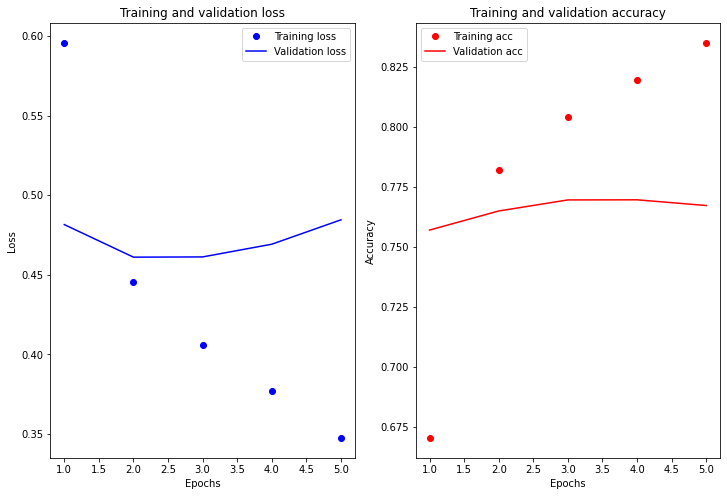

In [26]:
history_1dcnn_pre_dict = history_1dcnn_pre.history

acc = history_1dcnn_pre_dict['accuracy']
val_acc = history_1dcnn_pre_dict['val_accuracy']
loss = history_1dcnn_pre_dict['loss']
val_loss = history_1dcnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
results = model_1dcnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4896 - accuracy: 0.7651
[0.4896228015422821, 0.7650995850563049]


----
### 5-4. 1-D Convolution Neural Network(1-D CNN) - post 패딩 데이터 사용

In [28]:
model_1dcnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_post = model_1dcnn_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 2s 9ms/step - loss: 0.6522 - accuracy: 0.5878 - val_loss: 0.3737 - val_accuracy: 0.8377
Epoch 2/5
198/198 [==============================] - 2s 8ms/step - loss: 0.3473 - accuracy: 0.8547 - val_loss: 0.3482 - val_accuracy: 0.8496
Epoch 3/5
198/198 [==============================] - 2s 8ms/step - loss: 0.3042 - accuracy: 0.8753 - val_loss: 0.3446 - val_accuracy: 0.8517
Epoch 4/5
198/198 [==============================] - 2s 8ms/step - loss: 0.2750 - accuracy: 0.8883 - val_loss: 0.3509 - val_accuracy: 0.8499
Epoch 5/5
198/198 [==============================] - 2s 8ms/step - loss: 0.2512 - accuracy: 0.9016 - val_loss: 0.3584 - val_accuracy: 0.8498


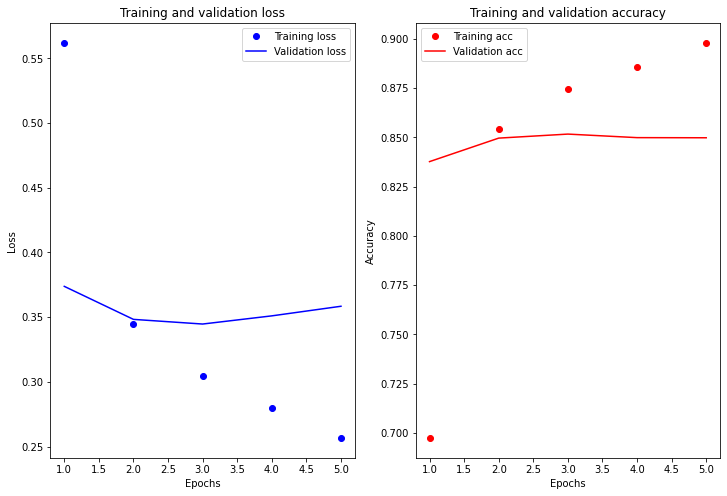

In [29]:
history_1dcnn_post_dict = history_1dcnn_post.history

acc = history_1dcnn_post_dict['accuracy']
val_acc = history_1dcnn_post_dict['val_accuracy']
loss = history_1dcnn_post_dict['loss']
val_loss = history_1dcnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
results = model_1dcnn_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3678 - accuracy: 0.8453
[0.36784476041793823, 0.8452509045600891]


----
### 5-5. GlobalMaxPooling1D() 레이어 - pre 패딩 데이터 사용

In [31]:
model_gmp_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_pre = model_gmp_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 2s 6ms/step - loss: 0.6684 - accuracy: 0.6680 - val_loss: 0.4832 - val_accuracy: 0.8115
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.4330 - accuracy: 0.8286 - val_loss: 0.3754 - val_accuracy: 0.8354
Epoch 3/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3465 - accuracy: 0.8524 - val_loss: 0.3581 - val_accuracy: 0.8426
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3107 - accuracy: 0.8711 - val_loss: 0.3556 - val_accuracy: 0.8449
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2856 - accuracy: 0.8836 - val_loss: 0.3585 - val_accuracy: 0.8451


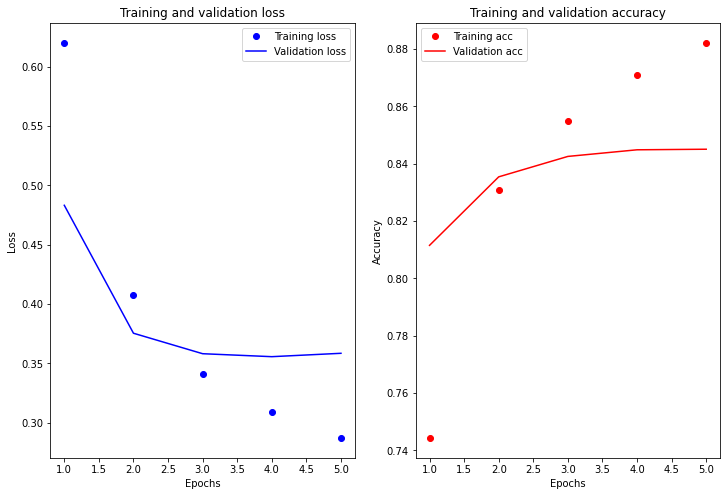

In [32]:
history_gmp_pre_dict = history_gmp_pre.history

acc = history_gmp_pre_dict['accuracy']
val_acc = history_gmp_pre_dict['val_accuracy']
loss = history_gmp_pre_dict['loss']
val_loss = history_gmp_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
results = model_gmp_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3698 - accuracy: 0.8402
[0.3698310852050781, 0.8401651978492737]


____
### 5-6. GlobalMaxPooling1D() 레이어 - post 패딩 데이터 사용

In [34]:
model_gmp_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_post = model_gmp_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 2s 6ms/step - loss: 0.6613 - accuracy: 0.6789 - val_loss: 0.4785 - val_accuracy: 0.8136
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.4309 - accuracy: 0.8282 - val_loss: 0.3727 - val_accuracy: 0.8365
Epoch 3/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3397 - accuracy: 0.8564 - val_loss: 0.3555 - val_accuracy: 0.8442
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3010 - accuracy: 0.8753 - val_loss: 0.3527 - val_accuracy: 0.8475
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2799 - accuracy: 0.8857 - val_loss: 0.3558 - val_accuracy: 0.8470


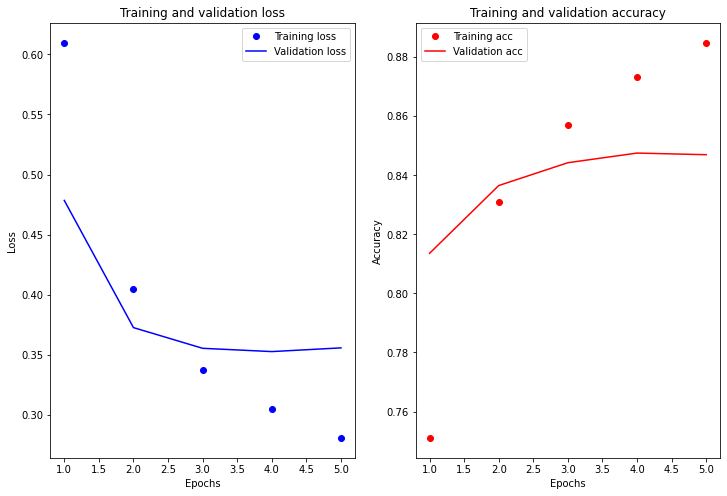

In [35]:
history_gmp_post_dict = history_gmp_post.history

acc = history_gmp_post_dict['accuracy']
val_acc = history_gmp_post_dict['val_accuracy']
loss = history_gmp_post_dict['loss']
val_loss = history_gmp_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
results = model_gmp_post.evaluate(X_test_post,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3669 - accuracy: 0.8408
[0.36692285537719727, 0.8408161401748657]


### 모델 별 test set 예측  정확도(accuracy) 비교

|모델|앞 패딩(pre)적용 정확도|뒷 패딩(post) 적용 정확도|
|:----:|:----:|:----:|
|RNN (LSTM)|0.8431|0.8423|
|1-D CNN|0.7651|0.8453|
|GlobalMaxPooling1D() 레이어|0.8402|0.8408|

> RNN 모델의 경우, 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다.  
따라서 pre padding 이 적용되었을 때, 더 좋은 성능을 보였다.

> 위의 1-D CNN 모델의 경우, post 패딩을 적용했을 때의 정확도가 pre 패딩을 적용했을때보다 훨씬 높게 나온다. 이것의 원인을 한번 살펴볼 필요성이 있다.

Mahidhar Dwarampudi, N V Subba Reddy - __Effects of padding on LSTMs and CNNs (18 Mar 2019)__ 를 참고하면  
- LSTM과 달리 CNN모델에서는 무언가를 기억하려고 하지 않기 때문에 사전 패딩 및 사후 패딩은 CNN에 중요하지 않다. 그저 이전 출력에서 대신 주어진 데이터에서 패턴을 찾으려고 시도한다.   
- 감정 분석의 경우 LSTM이 CNN보다 효율적이다.
- LSTM의 경우, pre padding 으로 시퀀스를 채우는 것이 더 효율적이다.
- 일반적으로 여러 유형의 신경망이 결합되어 작업을 수행할 때 pre padding 이 더 좋다.

[참고 링크](https://arxiv.org/abs/1903.07288)

----
## 6. 학습된 임베딩 레이어 분석

model의 첫 번째 레이어는 바로 Embedding 레이어였다. 이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였다. 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것이다.   

위의 모델 중에 가장 성능이 좋게 나온 __pre 패딩을 적용한 데이터로 학습한 RNN 모델__ 을
워드 벡터를 다루는데 유용한 `gensim` 패키지를 사용하여   

단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법으로 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인해보자.

In [37]:
embedding_layer = model_rnn_pre.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [38]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_rnn_pre.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법으로 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("행복")

[('환상', 0.9627501964569092),
 ('염', 0.9523703455924988),
 ('very', 0.9484211206436157),
 ('울리', 0.9469653367996216),
 ('강해', 0.9461369514465332),
 ('헨리', 0.9423972964286804),
 ('해져요', 0.9401565790176392),
 ('、', 0.9392151236534119),
 ('소화', 0.9371898174285889),
 ('치도', 0.9355247616767883)]

In [40]:
word_vectors.similar_by_word("지루")

[('졸린', 0.9568641781806946),
 ('어려운', 0.9540711641311646),
 ('싫', 0.9485859274864197),
 ('털리', 0.9456669092178345),
 ('아까울', 0.9361624121665955),
 ('사업', 0.9343879818916321),
 ('막장', 0.9343835115432739),
 ('쯔쯔', 0.9337289929389954),
 ('지루함', 0.9333158731460571),
 ('비추', 0.931437075138092)]

위의 훈련데이터만으로는 워드 벡터를 정교하게 학습시키기 어렵다는 것을 알 수 있다.  

따라서 더 좋은 모델의 성능을 위해서는 한국어 Word2Vec 임베딩 활용한 성능개선이 필요하다.

## 7. 한국어 Word2Vec 임베딩 활용하여 성능개선

[Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors) 에서 한국어 Word2Vec 데이터를 불러와 사용하였다.

```
pip install --upgrade gensim==3.8.3
```

In [41]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['행복']
vector.shape     # 200dim의 워드 벡터

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(200,)

In [42]:
word2vec.similar_by_word("행복")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [43]:
word2vec.similar_by_word("지루")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('답답', 0.7367106676101685),
 ('편안', 0.7046725749969482),
 ('솔직', 0.689364492893219),
 ('쓸쓸', 0.6880695819854736),
 ('차분', 0.6868932247161865),
 ('조용', 0.6765609383583069),
 ('냉정', 0.6706622838973999),
 ('자유분방', 0.6680829524993896),
 ('피곤', 0.6597293019294739),
 ('느긋', 0.659047544002533)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있다.  

이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여  
RNN 모델(pre padding) 을 학습시켜보자.

### RNN 모델 생성

이때, LSTM 레이어의 LSTM state 벡터의 차원수를 기존 8 -> 128로 변경한다.

In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [45]:
# LSTM 레이어로 모델 설계
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_ko.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 학습 과정 시각화

In [46]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko = model_ko.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1581/1581 [==============================] - 35s 21ms/step - loss: 0.4738 - accuracy: 0.7665 - val_loss: 0.3413 - val_accuracy: 0.8518
Epoch 2/5
1581/1581 [==============================] - 33s 21ms/step - loss: 0.2940 - accuracy: 0.8764 - val_loss: 0.3113 - val_accuracy: 0.8672
Epoch 3/5
1581/1581 [==============================] - 31s 19ms/step - loss: 0.2423 - accuracy: 0.8995 - val_loss: 0.3179 - val_accuracy: 0.8657
Epoch 4/5
1581/1581 [==============================] - 30s 19ms/step - loss: 0.1950 - accuracy: 0.9221 - val_loss: 0.3334 - val_accuracy: 0.8608
Epoch 5/5
1581/1581 [==============================] - 32s 20ms/step - loss: 0.1567 - accuracy: 0.9400 - val_loss: 0.3733 - val_accuracy: 0.8611


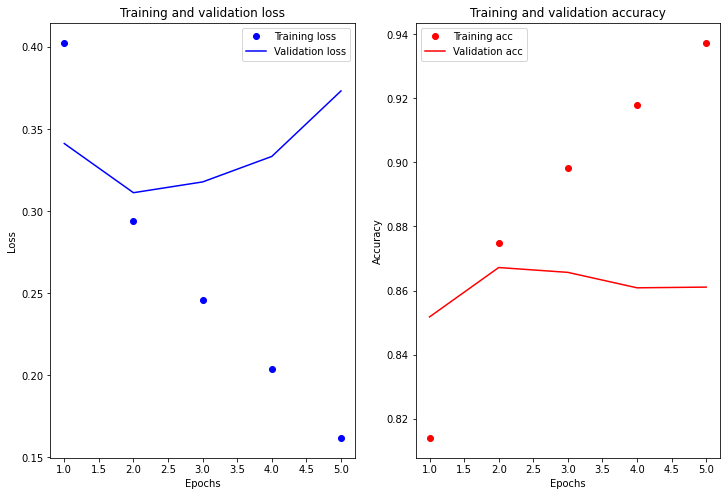

In [47]:
history_ko_dict = history_ko.history

acc = history_ko_dict['accuracy']
val_acc = history_ko_dict['val_accuracy']
loss = history_ko_dict['loss']
val_loss = history_ko_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3799 - accuracy: 0.8580
[0.37993860244750977, 0.8579856157302856]


한국어 Word2Vec 임베딩을 사용하여 새로 모델을 생성한 결과 test set 에서의 정확도는 __0.8580__ 으로 향상 된 것을 확인 할 수 있다.

## 8. Dropout, Bidirectional layer 

### Dropout 추가

Dropout이란 deep 한 neural network 모델을 만들 때 overfitting 문제를 해결하고 정규화된 모델을 만들기 위해 말 그대로 network 일부를 생략하는 방법이다. 생략된 network는 학습에 영향을 끼치지 않게 된다.


In [49]:
# LSTM 레이어로 모델 설계
model_ko_final = keras.Sequential()
model_ko_final.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko_final.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko_final.add(keras.layers.Dropout(0.25))                    # Dropout 추가
model_ko_final.add(keras.layers.Dense(8, activation='relu'))
model_ko_final.add(keras.layers.Dropout(0.3))                     # Dropout 추가
model_ko_final.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim
model_ko_final.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
____________________________________________

In [50]:
model_ko_final.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko_final = model_ko_final.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1581/1581 [==============================] - 34s 20ms/step - loss: 0.5328 - accuracy: 0.7335 - val_loss: 0.3384 - val_accuracy: 0.8536
Epoch 2/5
1581/1581 [==============================] - 30s 19ms/step - loss: 0.3504 - accuracy: 0.8620 - val_loss: 0.3229 - val_accuracy: 0.8610
Epoch 3/5
1581/1581 [==============================] - 33s 21ms/step - loss: 0.2931 - accuracy: 0.8874 - val_loss: 0.3174 - val_accuracy: 0.8662
Epoch 4/5
1581/1581 [==============================] - 31s 20ms/step - loss: 0.2595 - accuracy: 0.9023 - val_loss: 0.3218 - val_accuracy: 0.8646
Epoch 5/5
1581/1581 [==============================] - 30s 19ms/step - loss: 0.2217 - accuracy: 0.9185 - val_loss: 0.3582 - val_accuracy: 0.8648


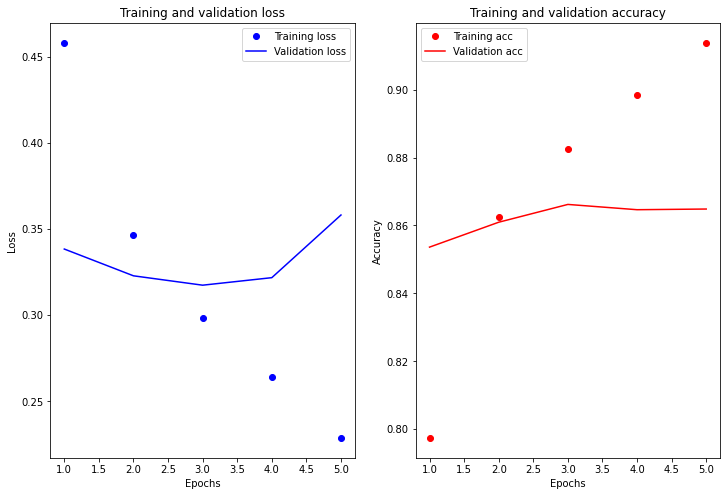

In [51]:
history_ko_final_dict = history_ko_final.history

acc = history_ko_final_dict['accuracy']
val_acc = history_ko_final_dict['val_accuracy']
loss = history_ko_final_dict['loss']
val_loss = history_ko_final_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
results = model_ko_final.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3642 - accuracy: 0.8621
[0.3641846776008606, 0.8620542287826538]


Dropout 을 추가하여 모델을 생성한 결과 test set 에서의 정확도는 __0.8621__ 으로 향상 된 것을 확인 할 수 있다.

### Bidirectional layer

참고 링크 : [Bidirectional layer](https://keras.io/api/layers/recurrent_layers/bidirectional/)

In [53]:
# LSTM 레이어로 모델 설계
model_ko_final_2 = keras.Sequential()
model_ko_final_2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko_final_2.add(keras.layers.Bidirectional(keras.layers.LSTM(128, recurrent_dropout=0)))   # Bidirectional layer
model_ko_final_2.add(keras.layers.Dropout(0.25))
model_ko_final_2.add(keras.layers.Dense(8, activation='relu'))
model_ko_final_2.add(keras.layers.Dropout(0.3))
model_ko_final_2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim
model_ko_final_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,338,961
Trainable params: 2,338,961
Non-trainable params: 0
____________________________________________

In [54]:
model_ko_final_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko_final_2 = model_ko_final_2.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1581/1581 [==============================] - 56s 34ms/step - loss: 0.5138 - accuracy: 0.7395 - val_loss: 0.3392 - val_accuracy: 0.8539
Epoch 2/5
1581/1581 [==============================] - 45s 28ms/step - loss: 0.3308 - accuracy: 0.8683 - val_loss: 0.3177 - val_accuracy: 0.8629
Epoch 3/5
1581/1581 [==============================] - 45s 28ms/step - loss: 0.2861 - accuracy: 0.8879 - val_loss: 0.3157 - val_accuracy: 0.8651
Epoch 4/5
1581/1581 [==============================] - 44s 28ms/step - loss: 0.2453 - accuracy: 0.9064 - val_loss: 0.3234 - val_accuracy: 0.8668
Epoch 5/5
1581/1581 [==============================] - 44s 28ms/step - loss: 0.2124 - accuracy: 0.9210 - val_loss: 0.3413 - val_accuracy: 0.8656


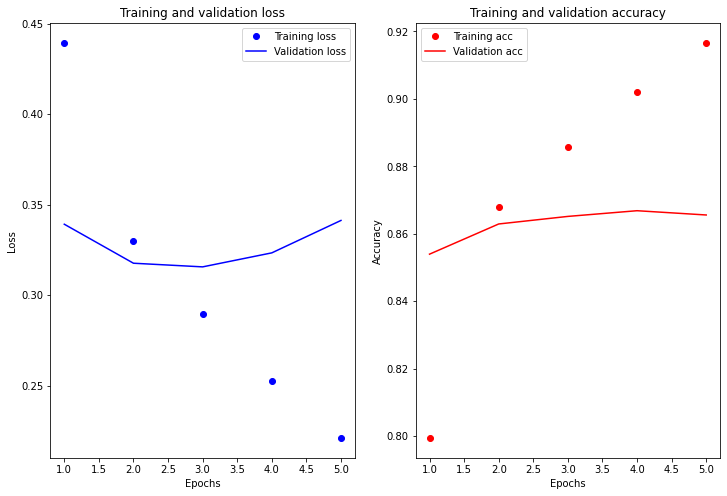

In [55]:
history_ko_final_2_dict = history_ko_final_2.history

acc = history_ko_final_2_dict['accuracy']
val_acc = history_ko_final_2_dict['val_accuracy']
loss = history_ko_final_2_dict['loss']
val_loss = history_ko_final_2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [56]:
results = model_ko_final_2.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.3508 - accuracy: 0.8614
[0.35077765583992004, 0.8614439368247986]


Bidirectional layer LSTM 으로 모델을 생성한 결과 test set 에서의 정확도는 0.8614 으로 이전과 거의 비슷한 것을 확인 할 수 있다.

----
# 프로젝트 정리

### 기본 데이터 셋을 이용한 모델의 정확도

|모델|앞 패딩(pre)적용 정확도|뒷 패딩(post) 적용 정확도|
|:----:|:----:|:----:|
|RNN (LSTM)|0.8437|0.8427|
|1-D CNN|0.7662|0.8424|
|GlobalMaxPooling1D() 레이어|0.8415|0.8415|

> RNN 모델의 경우, 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다.  
따라서 pre padding 이 적용되었을 때, 더 좋은 성능을 보였다.

> 위의 1-D CNN 모델의 경우, post 패딩을 적용했을 때의 정확도가 pre 패딩을 적용했을때보다 훨씬 높게 나온다. 이것의 원인을 한번 살펴볼 필요성이 있다.

Mahidhar Dwarampudi, N V Subba Reddy - __Effects of padding on LSTMs and CNNs (18 Mar 2019)__ 를 참고하면  
- LSTM과 달리 CNN모델에서는 무언가를 기억하려고 하지 않기 때문에 사전 패딩 및 사후 패딩은 CNN에 중요하지 않다. 그저 이전 출력에서 대신 주어진 데이터에서 패턴을 찾으려고 시도한다.   
- 감정 분석의 경우 LSTM이 CNN보다 효율적이다.
- LSTM의 경우, pre padding 으로 시퀀스를 채우는 것이 더 효율적이다.
- 일반적으로 여러 유형의 신경망이 결합되어 작업을 수행할 때 pre padding 이 더 좋다.

[참고 링크](https://arxiv.org/abs/1903.07288)

### 한국어 Word2Vec 임베딩 활용하여 성능개선

pre-padding 된 데이터로 학습 및 평가함

|모델|추가한 점|정확도|
|:----:|:----:|:----:|
|RNN (LSTM)||__0.8580__|
|RNN (LSTM)|Dropout|__0.8621__|
|RNN (LSTM)|Dropout, Bidirectional layer|__0.8614__|

한국어 Word2Vec 을 사용하여 임베딩을 진행하고 추가로 Dropout 을 진행한 결과 최종 test set의 정확도가 0.86정도로 나왔다.